In [44]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [45]:
def mad(data):
    median = np.median(data)  # 중앙값 계산
    deviations = np.abs(data - median)  # 데이터 포인트와 중앙값 간의 절대 편차 계산
    mad_value = np.median(deviations)  # 편차들의 중앙값 계산
    
    return mad_value

- Read Table

In [102]:
exptime = '060s'
exptime = '900s'

path_FitResult = f'../fit_result/kn2KN/040Mpc/{exptime}/med25nm'
# path_FitResult = f'../fit_result/kn2KN/040Mpc/{exptime}/broad_griz'
# path_FitResult = f'../fit_result/kn2KN/040Mpc/{exptime}/broad_ugriz'
restbl = Table.read(f'{path_FitResult}/fit_result.fits')

In [103]:
print(f"Detection: {len(restbl[restbl['det']==True])} ({1e2*len(restbl[restbl['det']==True])/len(restbl):.1f}%)")
print(f"Fit      : {len(restbl[restbl['det']==True])} ({1e2*len(restbl[restbl['fit']==True])/len(restbl):.1f}%)")

Detection: 3512 (97.6%)
Fit      : 3512 (97.6%)


- Filter with `fit` column

In [104]:
indx_fit = np.where(restbl['fit'])
# indx_fit = np.where((restbl['fit']) & (restbl['ndet']==restbl['ndet'].max()))
fitbl = restbl[indx_fit]

# Plots for Analysis

['input_table', 'ndet', 'det_filters', 'det', 'fit', 'z', 't', 'md', 'vd', 'mw', 'vw', key.upper(), 'zerr', 'terr', 'mderr', 'vderr', 'mwerr', 'vwerr', 'angerr', 'free_params', 'dof', 'chisq', 'chisqdof', 'bic', 'MD', 'VD', 'MW', 'VW', key.upper(), 'PHASE', 'REDSHIFT']

- Fitted Angle Error Distribution

In [105]:
key = 'ang'

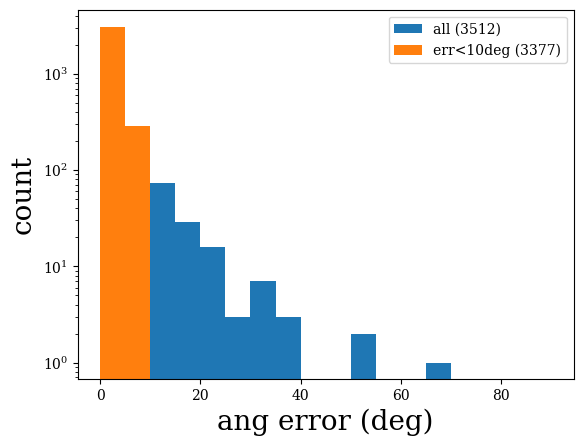

In [106]:
bins = np.arange(0, 90+5, 5)
indx_goodfit = np.where(fitbl[f'{key}err']<10)
plt.hist(fitbl[f'{key}err'], bins=bins, label=f'all ({len(fitbl)})')
plt.hist(fitbl[f'{key}err'][indx_goodfit], bins=bins, label=f'err<10deg ({len(indx_goodfit[0])})')
plt.xlabel(f'{key} error (deg)')
plt.ylabel('count')
plt.yscale('log')
plt.legend()

- residual

In [107]:
residual = fitbl[key] - fitbl[key.upper()]

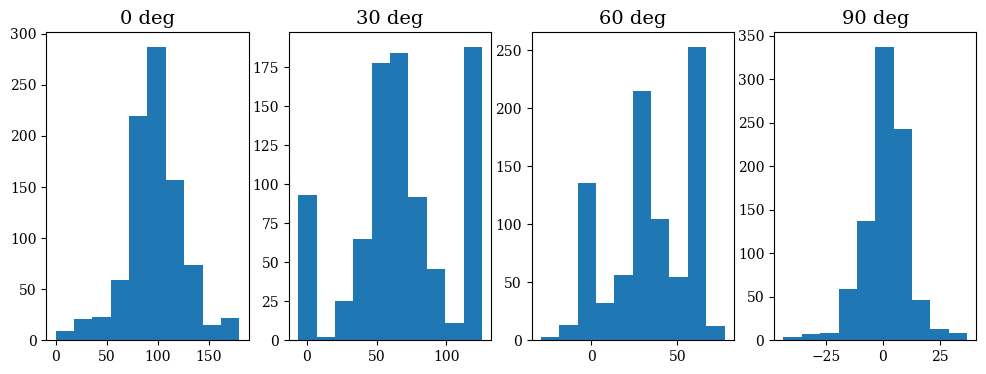

In [108]:
datalist = []
stdlist = []
medlist = []
madlist = []

fig = plt.figure(figsize=(12, 4))
for aa, ang in enumerate(np.unique(fitbl[key.upper()])):
	datalist.append(residual[fitbl[key.upper()]==ang])
	stdlist.append(np.std(residual[fitbl[key.upper()]==ang]))
	medlist.append(np.median(residual[fitbl[key.upper()]==ang]))
	madlist.append(mad(residual[fitbl[key.upper()]==ang]))

	ax = fig.add_subplot(1, 4, aa+1)
	ax.hist(residual[fitbl[key.upper()]==ang])
	ax.set_title(f"{ang} deg")
	# ax.set_xlim([-10, +10])

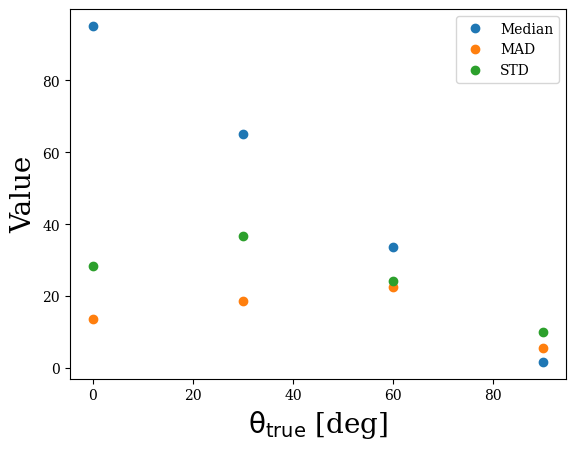

In [109]:
plt.plot(np.unique(fitbl[key.upper()]), medlist, 'o', label='Median')
plt.plot(np.unique(fitbl[key.upper()]), madlist, 'o', label='MAD')
plt.plot(np.unique(fitbl[key.upper()]), stdlist, 'o', label='STD')

# plt.ylim([-5, +5])
plt.xlabel(r'$\rm \theta_{true}$ [deg]')
plt.ylabel('Value')
plt.legend()

Text(0, 0.5, '$\\rm \\theta_{fit}-\\theta_{true}$')

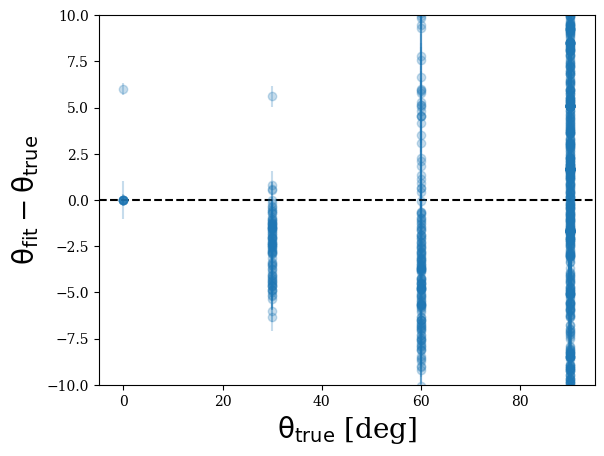

In [110]:
# plt.plot(fitbl[key.upper()], residual, '.')
# plt.plot(fitbl[key.upper()][indx_goodfit], residual[indx_goodfit], '.')
# plt.errorbar(fitbl[key.upper()][indx_goodfit], fitbl[key.upper()][indx_goodfit], yerr=fitbl['angerr'][indx_goodfit], marker='o', ls='', alpha=0.5)
plt.errorbar(fitbl[key.upper()][indx_goodfit], residual[indx_goodfit], yerr=fitbl['angerr'][indx_goodfit], marker='o', ls='', alpha=0.25)
plt.axhline(y=0, color='k', ls='--')
xl, xr = fitbl[key.upper()].min(), fitbl[key.upper()].max()
plt.xlim([xl-5, xr+5])
plt.ylim([-10, +10])

plt.xlabel(r'$\rm \theta_{true}$ [deg]')
plt.ylabel(r'$\rm \theta_{fit}-\theta_{true}$')

Text(0, 0.5, 'Median Residual')

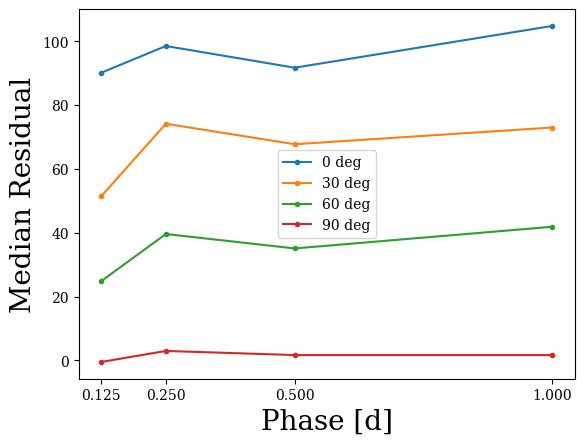

In [111]:
angarr = np.unique(fitbl[key.upper()])
ang = angarr[0]
# phase = phasearr[0]
phasearr = np.unique(fitbl['PHASE'])

for ang in angarr:
    vallist = []
    for phase in phasearr:
        val = np.median(residual[(fitbl['PHASE']==phase) & (fitbl[key.upper()]==ang)])
        vallist.append(val)

    plt.plot(phasearr, vallist, '.-', label=f'{ang} deg')

plt.legend()
plt.xlabel('Phase [d]')
plt.xticks(phasearr)
plt.ylabel('Median Residual')

# Quantities
- Bias
- NMAD
- Catastrophic Failure

## Bias

In [112]:
def func(x, a, b):
    return a * x + b

def calc_bias(true, fit):
    return abs(fit-true)/(1+true)

def calc_cpfailure(true, fit, frac=0.15):
    val = np.abs(fit - true) / (1 + true)
    count = np.count_nonzero(val > frac)
    fraction = count / len(val)
    return fraction

(-5.0, 185.0)

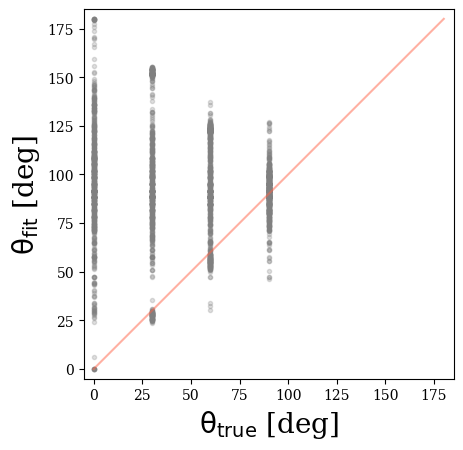

In [129]:
fig, ax = plt.subplots()

ax.plot(fitbl[key.upper()], fitbl[key], '.', c='grey', alpha=0.25)
# ax.plot(fitbl[key.upper()], fitbl[key.upper()], ls='-', c='tomato', alpha=0.5)
ax.plot([0, 180], [0, 180], ls='-', c='tomato', alpha=0.5)
ax.set_xlabel(r'$\rm \theta_{true}$ [deg]')
ax.set_ylabel(r'$\rm \theta_{fit}$ [deg]')
ax.set_aspect('equal')
# ax.set_xlim(fitbl[key.upper()].min()-5, fitbl[key.upper()].max()+5)
# ax.set_ylim(fitbl[key.upper()].min()-5, fitbl[key.upper()].max()+5)
ax.set_xlim(fitbl[key.upper()].min()-5, 180+5)
ax.set_ylim(fitbl[key.upper()].min()-5, 180+5)

In [114]:
# from scipy import stats
# x, y = fitbl[key.upper()], fitbl[key]
# res = stats.linregress(x, y)
# bias = res.intercept

# print(f"Bias: {bias:.3}")

In [115]:
for ang in angarr:
	bias = np.median(calc_bias(true=fitbl[key.upper()][fitbl[key.upper()]==ang], fit=fitbl[key][fitbl[key.upper()]==ang]))
	nmad = mad(residual[fitbl[key.upper()]==ang])
	frac_cpfailure = calc_cpfailure(fitbl[key.upper()][fitbl[key.upper()]==ang], fitbl[key][fitbl[key.upper()]==ang])
	print(f"[{ang:>3}deg] Bias:{bias:.3f}, NMAD:{nmad:.3f}, cpfailure:{frac_cpfailure*1e2:.1f}%")


[  0deg] Bias:95.098, NMAD:13.588, cpfailure:99.1%
[ 30deg] Bias:2.095, NMAD:18.625, cpfailure:90.7%
[ 60deg] Bias:0.551, NMAD:22.561, cpfailure:81.5%
[ 90deg] Bias:0.060, NMAD:5.545, cpfailure:13.1%


In [116]:
# fig, ax = plt.subplots()

# ax.plot(fitbl[key.upper()], fitbl[key], '.', c='grey', alpha=0.25)
# ax.plot(x, res.intercept + res.slope*x, 'r', lw=3, alpha=0.5, label=f'fitted line (a={res.slope:.3f}, b={res.intercept:.3f})')
# ax.set_xlabel(r'$\rm \theta_{true}$ [deg]')
# ax.set_ylabel(r'$\rm \theta_{fit}$ [deg]')
# plt.xticks(angarr)
# plt.yticks(angarr)
# plt.legend()
# ax.set_title(os.path.basename(path_FitResult))
# ax.set_xlim(min(x)-5, max(x)+5)
# ax.set_ylim(min(x)-5, max(x)+5)
# ax.set_aspect('equal')


## NMAD

In [117]:
bias = np.median(calc_bias(true=fitbl[key.upper()], fit=fitbl[key]))
nmad = mad(residual)
frac_cpfailure = calc_cpfailure(fitbl[key.upper()], fitbl[key])
print(f"[{os.path.basename(path_FitResult)}] Bias:{bias:.3f}, NMAD:{nmad:.3f}, cpfailure:{1e2*frac_cpfailure:.3f}%")

[med25nm] Bias:1.036, NMAD:40.564, cpfailure:71.469%


# Error Distribution

Text(0, 0.5, 'Norm. Cumulative Error')

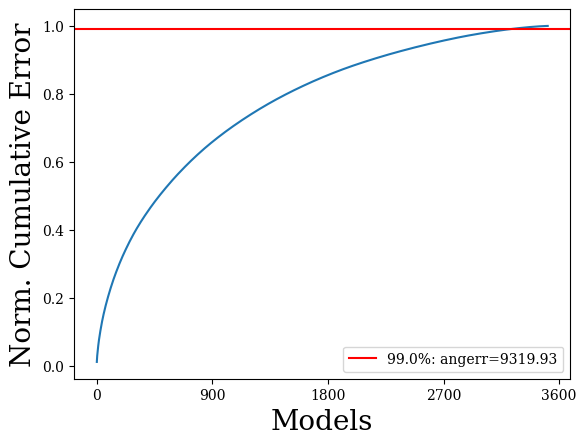

In [118]:
keyerr_cumsum = np.cumsum(fitbl[f'{key}err'][np.argsort(-1*fitbl[f'{key}err'])])
nkeyerr_cumsum = keyerr_cumsum/np.max(keyerr_cumsum)
plt.plot(nkeyerr_cumsum,)
cumcut = 0.99
cutval = np.interp(cumcut, nkeyerr_cumsum, keyerr_cumsum)
plt.axhline(y=cumcut, c='r', label=f'{cumcut*1e2:.1f}%: {key}err={cutval:.2f}')
_ = plt.xticks(np.arange(0, 3600+900, 900))
plt.legend()
plt.xlabel("Models")
plt.ylabel("Norm. Cumulative Error")

Text(0, 0.5, 'Norm. Cumulative Error')

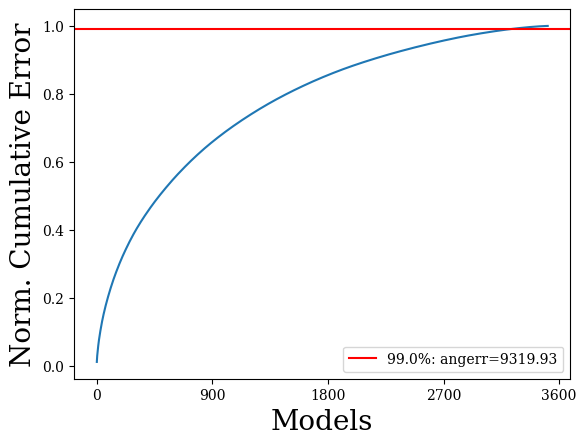

In [119]:
keyerr_cumsum = np.cumsum(fitbl[f'{key}err'][np.argsort(-1*fitbl[f'{key}err'])])
nkeyerr_cumsum = keyerr_cumsum/np.max(keyerr_cumsum)
plt.plot(nkeyerr_cumsum,)
cumcut = 0.99
cutval = np.interp(cumcut, nkeyerr_cumsum, keyerr_cumsum)
plt.axhline(y=cumcut, c='r', label=f'{cumcut*1e2:.1f}%: {key}err={cutval:.2f}')
_ = plt.xticks(np.arange(0, 3600+900, 900))
plt.legend()
plt.xlabel("Models")
plt.ylabel("Norm. Cumulative Error")